In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib notebook

# https://stackoverflow.com/questions/28320247/density-plot-on-a-sphere-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import sys
import chart_studio.plotly as py
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter

sys.path.append('../fibermetric/')
import sta_validate
import histology
import apsym_kmeans

# make figures for 2D experiments

## Experiment 1: 2D single orienation

In [ ]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
# sta_out = '../outputs/sta_validate_outputs/sta_2d_out/'
sta_out = '../outputs/sta_validate_outputs/sta_2d_iso-blur_out/'
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='.'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
print(errors_df.iloc[0])
errors_df.iloc[0]

## Figure 1: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [ ]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

In [ ]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    # set tick locations
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
# set figure title
fig.suptitle('2D Single Angle')

## figure 2: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [ ]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')


## figure 3: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [ ]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

In [ ]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
# fig.suptitle('2D Single Angle')


## Experiment 2: 2D two angles

In [ ]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())
print(len(files))

In [ ]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

In [ ]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
fig.suptitle('2D Two Angles')


In [ ]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

In [ ]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
# fig, axs = plt.subplots(2, sharex=True)
# axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
# axs[0].set_ylim(-0.1,2.6)
# axs[0].set_yticks(np.arange(0.0,2.75,0.25))
# axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
# axs[1].set_ylim(-0.2,5.2)
# axs[1].set_yticks(np.arange(0.0,5.5,0.5))
# axs[0].set_ylabel('best gradient sigma')
# axs[1].set_ylabel('best window sigma')
# axs[1].set_xlabel('anisotropy ratio')

In [ ]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
# fig.suptitle('2D Two Angles')

# 3D experiments

## Experiment 4: single orientation

In [ ]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
# sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v3/'
# sta_out = '../outputs/sta_validate_outputs/sta_3d_iso-blur_out_v3/'
sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v5/'

files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='_'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
errors_df.iloc[0]

## figure 7: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [ ]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

In [ ]:
errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

In [ ]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    # set tick locations
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
# set figure title
fig.suptitle('3D Single Angle')

## figure 8: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [ ]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

## figure 9: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [ ]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

In [ ]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')



## Error vs angle

In [ ]:
import scipy


df = errors_df.query(f'derivative_sigma=={derivative_sigmas[9]} and tensor_sigma=={tensor_sigmas[4]} and AI==1.0 and period==10.0')

errors = df['error']
angles = df['angles']
angles = np.array([np.array(a) for a in angles])
plt.figure()
plt.scatter(angles[:,1], errors)
plt.xlabel('angle (degrees)')
plt.ylabel('error (degrees)')
correlation = scipy.stats.pearsonr(angles[:,0], errors)
print(correlation)

## Experiment 5: 3D two angles

In [ ]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

## figure 10: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [ ]:
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

In [ ]:
tensor_sigmas

In [ ]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
fig.suptitle('3D Two Angles')


## figure 11: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [ ]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

## figure 12: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [ ]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')

## How does delta angle affect error?

In [ ]:
df = errors_df.query(f'derivative_sigma=={derivative_sigmas[5]} and tensor_sigma=={tensor_sigmas[3]} and AI==3.0 and period==10.0')

errors = df['error']
angles = df['angles']
delta = np.empty(len(angles))
mean = np.empty((len(angles), 2))
for i,a in enumerate(angles):
    u = np.array([np.sin(a[0][0])*np.sin(a[0][1]), np.sin(a[0][0])*np.cos(a[0][1]), np.cos(a[0][0])])
    v = np.array([np.sin(a[1][0])*np.sin(a[1][1]), np.sin(a[1][0])*np.cos(a[1][1]), np.cos(a[1][0])])
    dp = np.dot(u,v)
    delta[i] = np.arccos(np.abs(dp))
    sign = np.sign(dp)
    m = np.mean((sign*u,v), axis=0)
    m = m / np.linalg.norm(m)
    mean[i] = np.array([np.arccos(m[2]), np.arctan2(m[0], m[1])])

# scatter plot of errors by delta
plt.figure()
plt.scatter(delta, errors)
plt.xlabel('delta')
plt.ylabel('error')

# histogram of errors
plt.figure()
plt.hist(errors, bins=20)
plt.xlabel('error (degrees)')
plt.ylabel('count')



In [ ]:
print(df.iloc[np.argmax(df['error'])]['angles'])
print(df.iloc[np.argmax(df['error'])])
print(derivative_sigmas[4])
print(tensor_sigmas[2])



# Pipeline Figures

# first we generate a phantom with specified line orienations, period, and anisotropy  

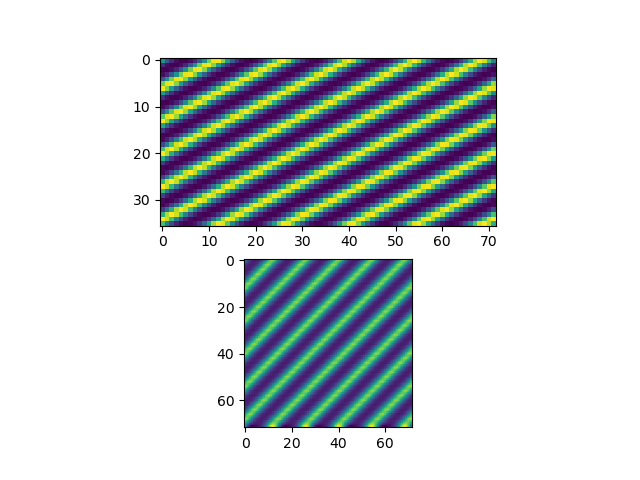

In [3]:
# in 2D
n = (36, 72)
d = (2.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([3*np.pi/4])
img = sta_validate.make_phantom(x, angles, interp=False)
img_upsampled = sta_validate.make_phantom(x, angles)

fig, axs = plt.subplots(2)
axs[0].imshow(img)
axs[1].imshow(img_upsampled)

True

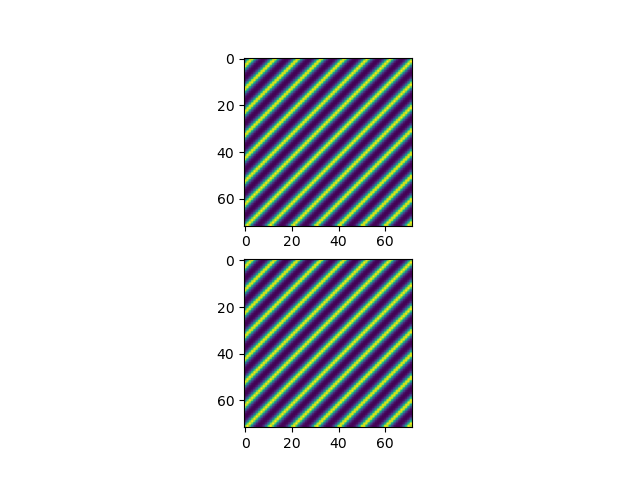

In [4]:
# in 2D
n = (72, 72)
d = (1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([3*np.pi/4])
img = sta_validate.make_phantom(x, angles, period=7.0)
sigma = 2.0
img_blur = gaussian_filter(img, sigma=0.0)
# img_blur5 = gaussian_filter(gaussian_filter(gaussian_filter(gaussian_filter(img_blur, sigma), sigma), sigma), sigma)
# img_blur5_alt = gaussian_filter(img, sigma=(4*sigma))

fig, axs = plt.subplots(2)
axs[0].imshow(img)
axs[1].imshow(img_blur)
np.allclose(img, img_blur)
# axs[1].imshow(img_blur5, vmin=0.0, vmax=0.15)
# axs[2].imshow(img_blur5_alt, vmin=0.0, vmax=0.15)

# start,stop = (28,46)
# axs[0].imshow(img[start:stop, start:stop])
# axs[1].imshow(img_blur5[start:stop, start:stop])
# axs[2].imshow(img_blur5_alt[start:stop, start:stop])

# print(np.sum(np.abs(img_blur5[start:stop, start:stop]-img_blur5_alt[start:stop, start:stop]))/np.mean(img_blur5[start:stop, start:stop]))


In [ ]:
errors_df['angles'].iloc[0].shape


In [29]:
plt.close('all')

[[0.         0.        ]
 [0.78539816 0.        ]]


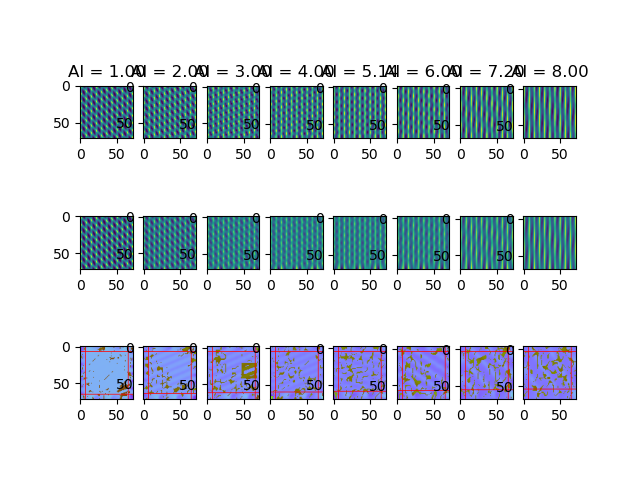

In [33]:
# in 3D
shapes = [(72,72,72), (36,72,72), (24,72,72), (18,72,72), (14,72,72), (12,72,72), (10,72,72), (9,72,72)]
AI = [d[1]/d[0] for d in shapes]
period=7.0
true_thetas = np.array([[0.0, 0.0],
                        [np.pi/4, 0.0]])
sigma0 = 2.5
sigma1 = 2.5
# true_thetas = np.array([np.pi/4, 3*np.pi/4])
# true_thetas = errors_df['angles'].iloc[0]
# true_thetas = np.array([[np.pi/2, 0.0],
                        # [np.pi/3, np.pi/4]])
print(true_thetas)
fig, ax = plt.subplots(3,8)
for i in range(ax.shape[1]):
    n = shapes[i]
    d = (n[1]/n[0], 1.0, 1.0)
    x = [np.arange(ni)*di for ni, di in zip(n, d)]
    img = sta_validate.make_phantom(x, true_thetas, period=period, interp=False, noise=1e-12)
    img_up = sta_validate.make_phantom(x, true_thetas, period=period, noise=1e-12)
    S = histology.structure_tensor(img_up, derivative_sigma=sigma0, tensor_sigma=sigma1, normalize=True)
    angles = histology.angles(S, cartesian=True)
    angles = (angles - np.min(angles)) / (np.max(angles)-np.min(angles))
    crop = round(max(sigma0,sigma1)*8.0/3) # two-thirds the radius of the largest kernel
    crop_end = round(AI[i]) - 1
    crop_color = [1.0,0.0,0.0]
    angles[crop] = crop_color
    angles[-crop-crop_end] = crop_color
    angles[:,crop] = crop_color
    angles[:,-crop] = crop_color
    angles[:,:,crop] = crop_color
    angles[:,:,-crop] = crop_color
    extent = (x[1][0]-d[1]/2, x[1][-1]+d[1]/2, x[0][-1]+d[0]/2, x[0][0]-d[0]/2)
    ax[0][i].imshow(img[:,:,36], extent=extent)
    ax[0][i].set_title(f'AI = {d[0]:.2f}')
    ax[1][i].imshow(img_up[:,:,36], extent=extent)
    ax[2][i].imshow(angles[:,:,36], extent=extent)


In [ ]:
blur_factor = np.sqrt(d[0]**2 - 1.0)
# blur_factor = d[0] - d[1]
new_image = gaussian_filter(img, sigma=[0.0, blur_factor, blur_factor])

plt.figure()
plt.imshow(new_image[:,36])

In [ ]:
# visualize with volume plot
Z,Y,X = np.mgrid[0:72:1,0:72:1,0:72:1]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=img.flatten(),
    isomin=0.04,
    isomax=0.23,
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=8, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=True,
    width=800,
    height=800,)
fig.show()
# py.iplot(fig, filename='volume_rendering')


## Next compute angles from structure tensors

In [ ]:
S = histology.structure_tensor(img, derivative_sigma=0.75, tensor_sigma=5.0, dI=d, masked=False)
angles = histology.angles(S, cartesian=True)
plt.figure()
plt.imshow(angles[:,36,:,0])#, cmap='hsv')
plt.colorbar()

In [ ]:
angles_ = angles.reshape((-1,angles.shape[-1]))

true_thetas_ = np.array([np.sin(true_thetas[0])*np.sin(true_thetas[1]),
                                np.sin(true_thetas[0])*np.cos(true_thetas[1]),
                                np.cos(true_thetas[0])
                                ])
skm = apsym_kmeans.APSymKMeans(n_clusters=1)
skm.fit(angles_)
mu_ = skm.cluster_centers_
# convert mu_ from cartesian to spherical coordinates
mu = np.array([np.arccos(mu_[0][2]), np.arctan2(mu_[0][0], mu_[0][1])])
diff = np.arccos(np.abs(mu_.dot(true_thetas_))) * 180/np.pi

print(mu)
print(true_thetas)

In [ ]:
print(diff)